In [1]:
# Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# import math
# import zipfile
# import pickle

from ml_library.config import *
from ml_library.utils import *
from ml_library.model import *



def preprocess_data(x, y):
    # Make all image array values fall within the range -1 to 1
    # Note all values in original images are between 0 and 255, as uint8
    x = x.astype('float32')
#     x = (x - 128.) #/ 128.

    # Convert the labels from numerical labels to one-hot encoded labels
    y_onehot = np.zeros((y.shape[0], NUM_CLASSES))
    for i, onehot_label in enumerate(y_onehot):
        onehot_label[y[i]] = 1.
    y = y_onehot

    return x, y

model = Model()

x, y, logits, predictions, accuracy = model.x, model.y, model.logits, model.predictions, model.accuracy
keep_prob = model.keep_prob
loss = model.loss

grad = tf.sign(tf.gradients(loss, x))[0]

# Load data
testing_file = "./Datasets/GTSRB_Final_Test_Images.zip"
test = generateTensor(testing_file)
x_test, y_test = preprocess_data(split(test))
label_map = map_labels('signnames.csv')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
grad = tf.sign(tf.gradients(model.reg_loss, x))[0]
# grad = tf.sign(tf.gradients(model.loss, x))[0]
def attack(sess, images, labels):

    eps = 3
    step_size = 1
    x = np.copy(images)
    
    for i in range(10):
        gradients = sess.run(grad, feed_dict={model.x: x, model.y: labels, model.keep_prob: 1.})
        x = x - step_size*gradients
        x = np.clip(x, images - eps, images + eps)
        x = np.clip(x, 0., 255.)

    return x

In [3]:
from scipy.ndimage.filters import gaussian_filter

def blur(images, eps):
    batch_size = images.shape[0]
    x = np.zeros(images.shape)
    for i in range(batch_size):
        image = images[i].reshape(32, 32, 3)
        temp = gaussian_filter(image, sigma=0.5+eps*0.1)
        x[i] = temp
    return x

In [4]:
import copy
def ocul(images, eps):
    batch_size = images.shape[0]
    x = copy.copy(images)
    for i in range(batch_size):
        image = images[i].reshape(32, 32, 3)
        idx = np.random.randint(0, 32-eps)
        x[i, idx:idx+eps, idx:idx+eps, :] = 0.
#         x[i] = image
    return x

In [5]:
def dark(images, eps):
    x = copy.copy(images)
    x = x - eps*10
    x = np.clip(x, 0., 255.)
    return x

In [6]:
def light(images, eps):
    x = copy.copy(images)
    x = x + eps*10
    x = np.clip(x, 0., 255.)
    return x

In [14]:
with tf.Session() as sess:

    saver = tf.train.Saver()
    filename = tf.train.latest_checkpoint("./robust_model_100/")
#     filename = tf.train.latest_checkpoint("./natural_model/")
    print("Latest training checkpoint is ", filename)
    if filename != None:
        saver.restore(sess, filename)
    else:
        print("No checkpoint found, exit.")
        exit()

    # Accuracy = 0
    # num = 10
    # batch_size = math.ceil(x_test.shape[0] / num)
    test_gen = next_batch(x_test, y_test, 1000, True)
    images, labels = next(test_gen)
    acc = sess.run(model.accuracy, feed_dict={x: images, y: labels, keep_prob: 1})
    for i in range(20):
        # Run testing on each batch
        adv_images = blur(images, i)
#         adv_images = ocul(images, i)
#         adv_images = dark(images, i)
#         adv_images = light(images, i)
        # Perform gradient update (i.e. training step) on current batch
        adv_acc = sess.run(model.accuracy, feed_dict={x: adv_images, y: labels, keep_prob: 1})
#         print("Blur sigma %.1f vs. Accuracy vs Adv_Accuracy：" % (0.5+i*0.1), acc, adv_acc)
        print("Darkness %.2d  vs. Accuracy vs Adv_Accuracy：" % i, acc, adv_acc)
#         grad_loss = sess.run(model.grad_loss, feed_dict={x: images, y: labels, keep_prob: 1})
#         print(grad_loss)

#         idx = sess.run(model.predictions, feed_dict={x: images, y: labels, keep_prob: 1})

#         adv_idx = sess.run(model.predictions, feed_dict={x: adv_images, y: labels, keep_prob: 1})
#         print("Original Label is:", label_map[np.argmax(labels[0])])

#         plt.subplot(1,2,1)
#         plt.imshow(images.reshape((32, 32, 3)))
#         plt.title(label_map[idx[0]])
#         plt.subplot(1,2,2)
#         plt.imshow(images.reshape((32, 32, 3)))
#         plt.title(label_map[adv_idx[0]])
#         plt.show()
        # 		print(label_map[idx[0]], label_map[adv_idx[0]])

Latest training checkpoint is  ./robust_model_100/checkpoint-153720
INFO:tensorflow:Restoring parameters from ./robust_model_100/checkpoint-153720
Darkness 00  vs. Accuracy vs Adv_Accuracy： 0.946 0.937
Darkness 01  vs. Accuracy vs Adv_Accuracy： 0.946 0.927
Darkness 02  vs. Accuracy vs Adv_Accuracy： 0.946 0.916
Darkness 03  vs. Accuracy vs Adv_Accuracy： 0.946 0.899
Darkness 04  vs. Accuracy vs Adv_Accuracy： 0.946 0.885
Darkness 05  vs. Accuracy vs Adv_Accuracy： 0.946 0.868
Darkness 06  vs. Accuracy vs Adv_Accuracy： 0.946 0.852
Darkness 07  vs. Accuracy vs Adv_Accuracy： 0.946 0.834
Darkness 08  vs. Accuracy vs Adv_Accuracy： 0.946 0.815
Darkness 09  vs. Accuracy vs Adv_Accuracy： 0.946 0.782
Darkness 10  vs. Accuracy vs Adv_Accuracy： 0.946 0.753
Darkness 11  vs. Accuracy vs Adv_Accuracy： 0.946 0.726
Darkness 12  vs. Accuracy vs Adv_Accuracy： 0.946 0.686
Darkness 13  vs. Accuracy vs Adv_Accuracy： 0.946 0.644
Darkness 14  vs. Accuracy vs Adv_Accuracy： 0.946 0.592
Darkness 15  vs. Accuracy vs

In [8]:
with tf.Session() as sess:

    saver = tf.train.Saver()
    filename = tf.train.latest_checkpoint("./robust_model_100/")
    print("Latest training checkpoint is ", filename)
    if filename != None:
        saver.restore(sess, filename)
    else:
        print("No checkpoint found, exit.")
        exit()

    # Accuracy = 0
    # num = 10
    # batch_size = math.ceil(x_test.shape[0] / num)
    test_gen = next_batch(x_test, y_test, 1000, True)

    for i in range(1):

        # Run testing on each batch
        images, labels = next(test_gen)

        adv_images = attack(sess, images, labels)
        # Perform gradient update (i.e. training step) on current batch
        acc = sess.run(model.accuracy, feed_dict={x: images, y: labels, keep_prob: 1})
        adv_acc = sess.run(model.accuracy, feed_dict={x: adv_images, y: labels, keep_prob: 1})
        print("Accuracy vs Adv_Accuracy：", acc, adv_acc)
        grad_loss = sess.run(model.grad_loss, feed_dict={x: images, y: labels, keep_prob: 1})
        print(grad_loss)

#         idx = sess.run(model.predictions, feed_dict={x: images, y: labels, keep_prob: 1})

#         adv_idx = sess.run(model.predictions, feed_dict={x: adv_images, y: labels, keep_prob: 1})
#         print("Original Label is:", label_map[np.argmax(labels[0])])

#         plt.subplot(1,2,1)
#         plt.imshow(images.reshape((32, 32, 3)))
#         plt.title(label_map[idx[0]])
#         plt.subplot(1,2,2)
#         plt.imshow(images.reshape((32, 32, 3)))
#         plt.title(label_map[adv_idx[0]])
#         plt.show()
        # 		print(label_map[idx[0]], label_map[adv_idx[0]])

Latest training checkpoint is  ./robust_model_100/checkpoint-153720
INFO:tensorflow:Restoring parameters from ./robust_model_100/checkpoint-153720
Accuracy vs Adv_Accuracy： 0.946 0.609
8.238152e-08


In [9]:
with tf.Session() as sess:

    saver = tf.train.Saver()
    filename = tf.train.latest_checkpoint("./natural_model/")
    print("Latest training checkpoint is ", filename)
    if filename != None:
        saver.restore(sess, filename)
    else:
        print("No checkpoint found, exit.")
        exit()

    # Accuracy = 0
    # num = 10
    # batch_size = math.ceil(x_test.shape[0] / num)
    test_gen = next_batch(x_test, y_test, 1000, True)

    for i in range(1):

        # Run testing on each batch
        images, labels = next(test_gen)

        adv_images = attack(sess, images, labels)

        # Perform gradient update (i.e. training step) on current batch
        acc = sess.run(model.accuracy, feed_dict={x: images, y: labels, keep_prob: 1})
        adv_acc = sess.run(model.accuracy, feed_dict={x: adv_images, y: labels, keep_prob: 1})
        print("Accuracy vs Adv_Accuracy：", acc, adv_acc)
        grad_loss = sess.run(model.grad_loss, feed_dict={x: images, y: labels, keep_prob: 1})
        print(grad_loss)

#         idx = sess.run(model.predictions, feed_dict={x: images, y: labels, keep_prob: 1})

#         adv_idx = sess.run(model.predictions, feed_dict={x: adv_images, y: labels, keep_prob: 1})
#         print("Original Label is:", label_map[np.argmax(labels[0])])

#         plt.subplot(1,2,1)
#         plt.imshow(images.reshape((32, 32, 3)))
#         plt.title(label_map[idx[0]])
#         plt.subplot(1,2,2)
#         plt.imshow(images.reshape((32, 32, 3)))
#         plt.title(label_map[adv_idx[0]])
#         plt.show()
        # 		print(label_map[idx[0]], label_map[adv_idx[0]])

Latest training checkpoint is  ./natural_model/checkpoint-50400
INFO:tensorflow:Restoring parameters from ./natural_model/checkpoint-50400
Accuracy vs Adv_Accuracy： 0.96 0.217
2.5545069e-06


Latest training checkpoint is  ./natural_model/checkpoint-25200
INFO:tensorflow:Restoring parameters from ./natural_model/checkpoint-25200


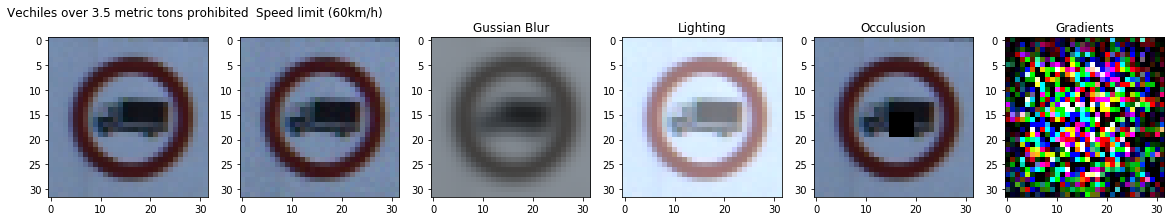

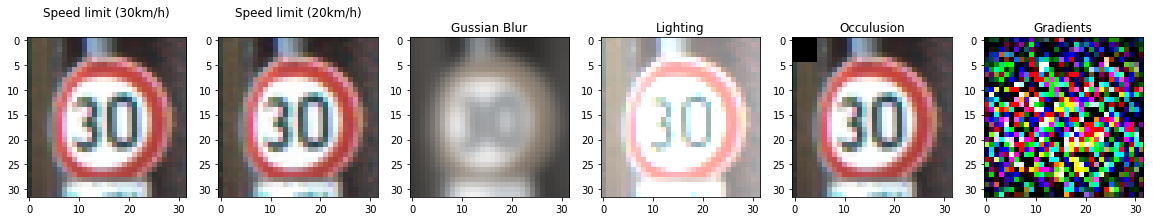

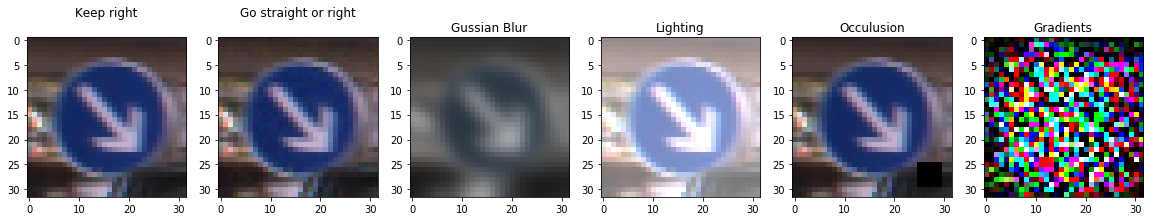

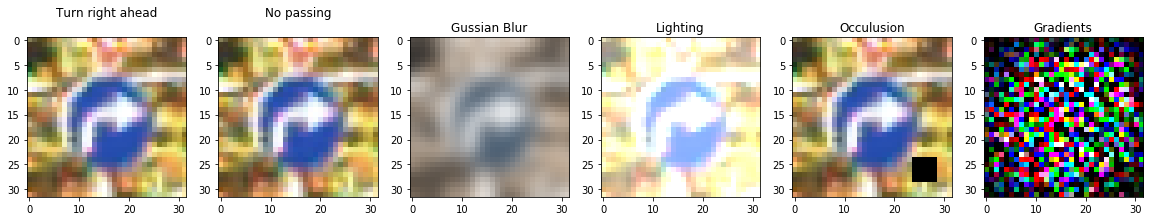

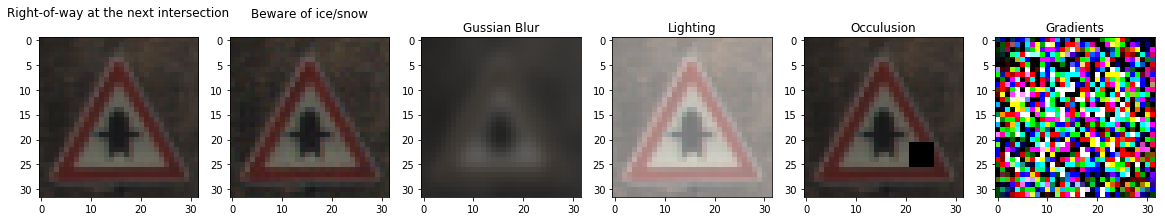

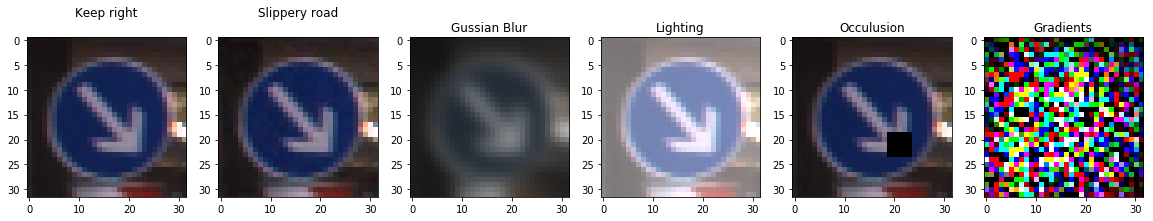

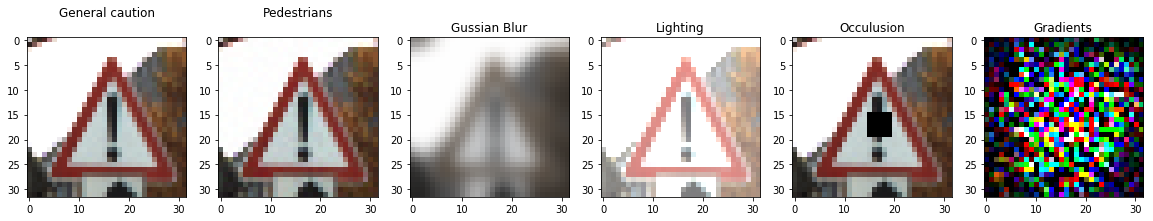

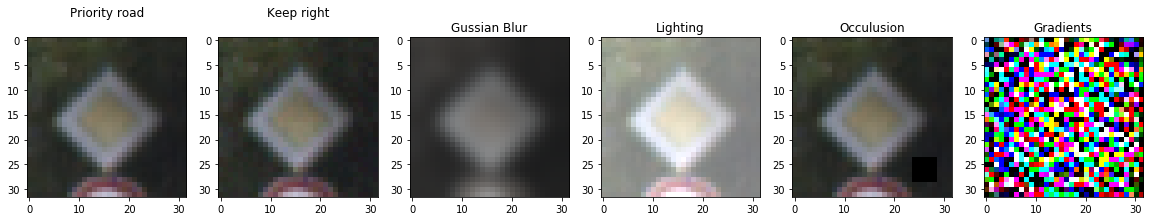

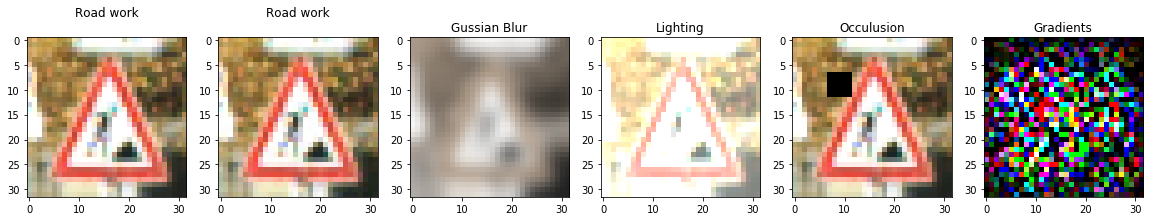

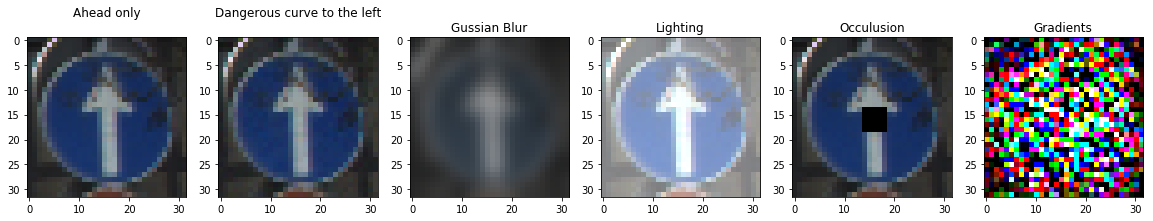

In [104]:
with tf.Session() as sess:

    saver = tf.train.Saver()
    filename = tf.train.latest_checkpoint("./natural_model/")
#     filename = tf.train.latest_checkpoint("./robust_model_100/")
    print("Latest training checkpoint is ", filename)
    if filename != None:
        saver.restore(sess, filename)
    else:
        print("No checkpoint found, exit.")
        exit()

    # Accuracy = 0
    # num = 10
    # batch_size = math.ceil(x_test.shape[0] / num)
    test_gen = next_batch(x_test, y_test, 1, True)
    

    for i in range(10):
        plt.figure(figsize=(20,10))
        # Run testing on each batch
        images, labels = next(test_gen)

        adv_images = attack(sess, images, labels)
        blr_images = blur(images, 10)
        ocl_images = ocul(images, 5)
        # drk_images = dark(images, 10)
        drk_images = light(images, 10)
        # Perform gradient update (i.e. training step) on current batch
        # acc = sess.run(model.accuracy, feed_dict={x: images, y: labels, keep_prob: 1})
        # adv_acc = sess.run(model.accuracy, feed_dict={x: adv_images, y: labels, keep_prob: 1})

        idx = sess.run(model.predictions, feed_dict={x: images, y: labels, keep_prob: 1})

        adv_idx = sess.run(model.predictions, feed_dict={x: adv_images, y: labels, keep_prob: 1})
        # print("Original Label is:", label_map[np.argmax(labels[0])])
        
        gradients = sess.run(model.vis, feed_dict={x: images, y: labels, keep_prob: 1})

        plt.subplot(1,6,1)
        images = images.astype(np.uint8)
        plt.imshow(images.reshape((32, 32, 3)))
        plt.title(label_map[idx[0]])
        
        plt.subplot(1,6,2)
        adv_images = adv_images.astype(np.uint8)
        plt.imshow(adv_images.reshape((32, 32, 3)))
        plt.title(label_map[adv_idx[0]])
        
        plt.subplot(1,6,3)
        blr_images = blr_images.astype(np.uint8)
        plt.imshow(blr_images.reshape((32, 32, 3)))
        plt.title("Gussian Blur")
        
        plt.subplot(1,6,4)
        drk_images = drk_images.astype(np.uint8)
        plt.imshow(drk_images.reshape((32, 32, 3)))
        plt.title("Lighting")
        
        plt.subplot(1,6,5)
        ocl_images = ocl_images.astype(np.uint8)
        plt.imshow(ocl_images.reshape((32, 32, 3)))
        plt.title("Occulusion")
        
        plt.subplot(1,6,6)
        gradients = gradients * 1000
        gradients = np.clip(gradients, 0., 1.)*255
        gradients = gradients.astype(np.uint8)
        plt.imshow(gradients.reshape((32, 32, 3)))
        plt.title("Gradients")
        plt.show()
        # print(gradients)
        # print(label_map[idx[0]], label_map[adv_idx[0]])

Latest training checkpoint is  ./robust_model_100/checkpoint-153720
INFO:tensorflow:Restoring parameters from ./robust_model_100/checkpoint-153720


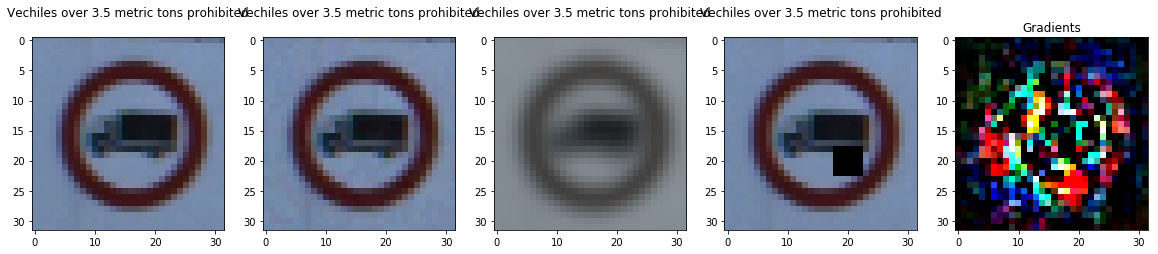

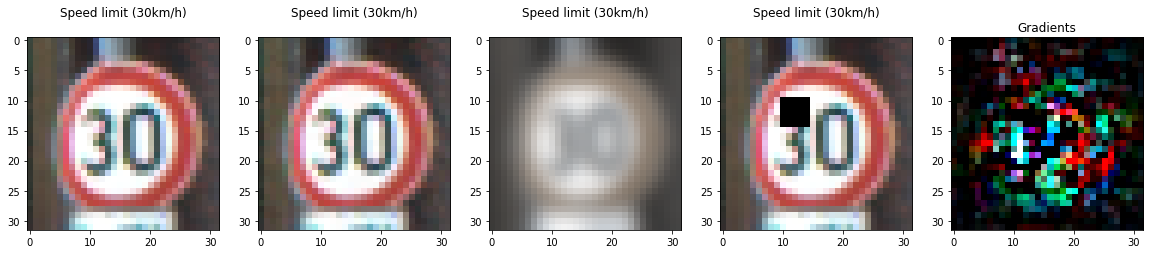

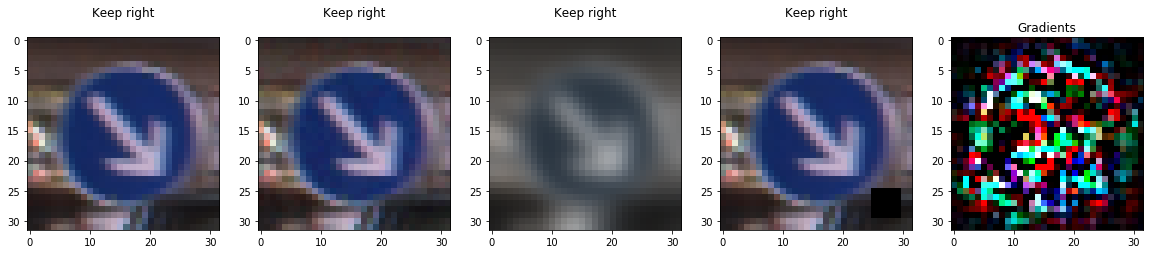

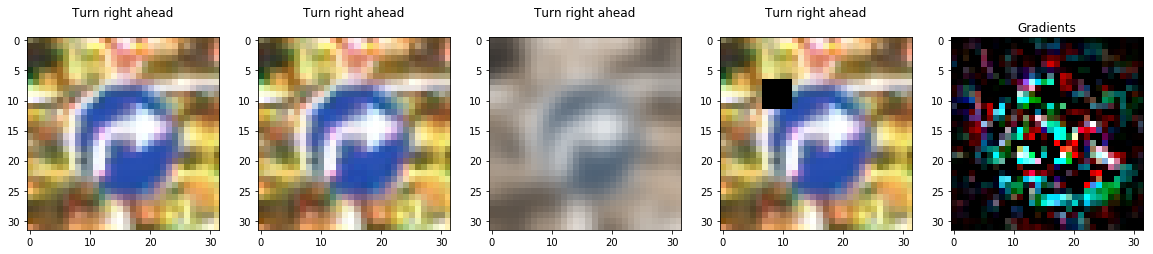

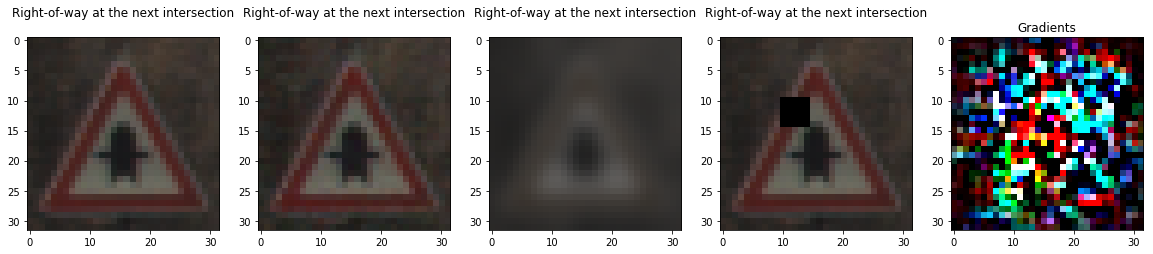

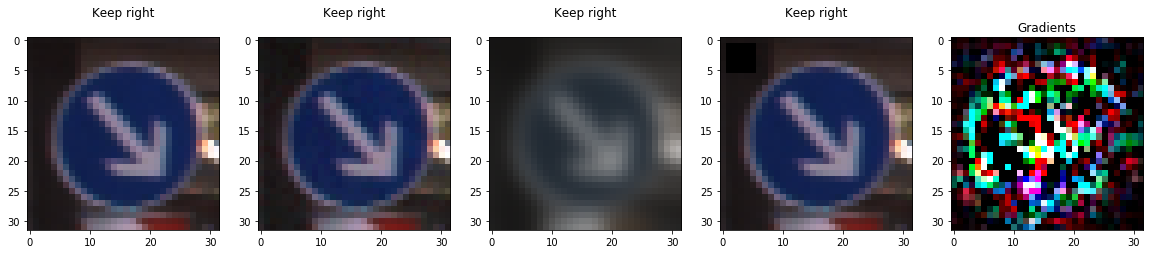

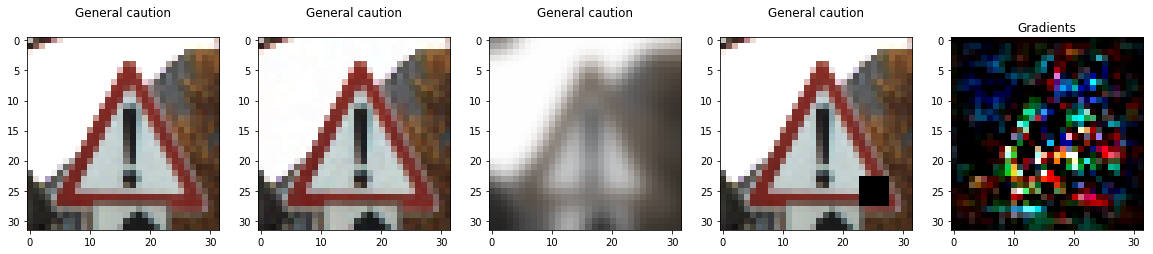

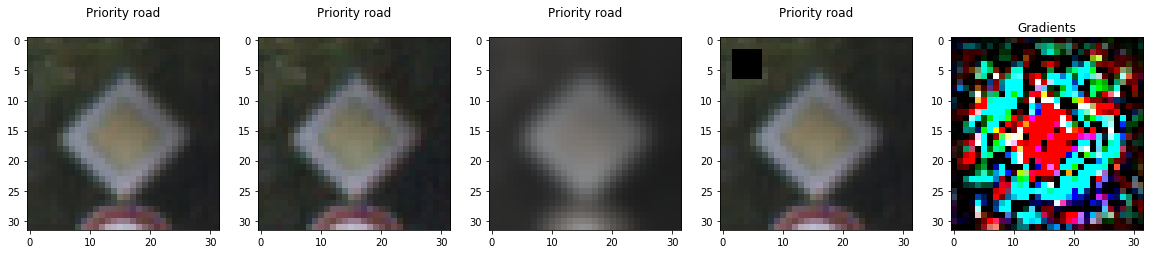

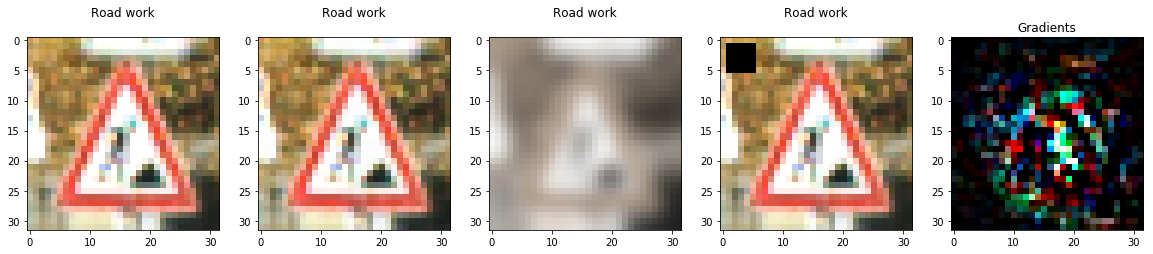

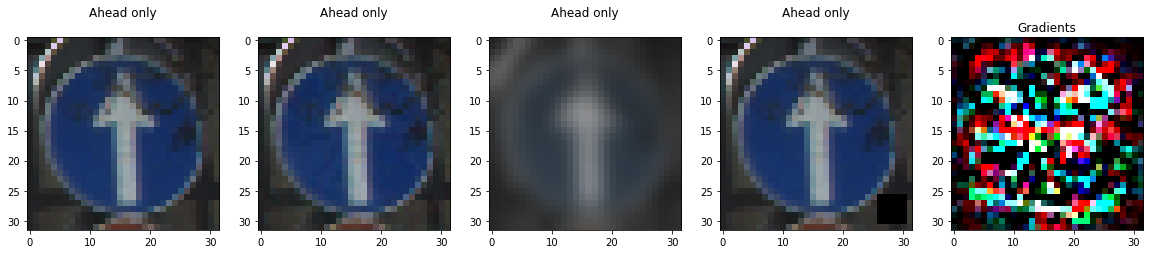

In [92]:
with tf.Session() as sess:

    saver = tf.train.Saver()
#     filename = tf.train.latest_checkpoint("./natural_model/")
    filename = tf.train.latest_checkpoint("./robust_model_100/")
    print("Latest training checkpoint is ", filename)
    if filename != None:
        saver.restore(sess, filename)
    else:
        print("No checkpoint found, exit.")
        exit()

    # Accuracy = 0
    # num = 10
    # batch_size = math.ceil(x_test.shape[0] / num)
    test_gen = next_batch(x_test, y_test, 1, True)

    for i in range(10):
        plt.figure(figsize=(20,10))
        # Run testing on each batch
        images, labels = next(test_gen)

        adv_images = attack(sess, images, labels)
        blr_images = blur(images, 10)
        ocl_images = ocul(images, 5)
        # Perform gradient update (i.e. training step) on current batch
        # acc = sess.run(model.accuracy, feed_dict={x: images, y: labels, keep_prob: 1})
        # adv_acc = sess.run(model.accuracy, feed_dict={x: adv_images, y: labels, keep_prob: 1})

        idx = sess.run(model.predictions, feed_dict={x: images, y: labels, keep_prob: 1})

        adv_idx = sess.run(model.predictions, feed_dict={x: adv_images, y: labels, keep_prob: 1})
#         print("Original Label is:", label_map[np.argmax(labels[0])])
        
        gradients = sess.run(model.vis, feed_dict={x: images, y: labels, keep_prob: 1})

        plt.subplot(1,5,1)
        images = images.astype(np.uint8)
        plt.imshow(images.reshape((32, 32, 3)))
        plt.title(label_map[idx[0]])
        
        plt.subplot(1,5,2)
        adv_images = adv_images.astype(np.uint8)
        plt.imshow(adv_images.reshape((32, 32, 3)))
        plt.title(label_map[adv_idx[0]])
        
        plt.subplot(1,5,3)
        blr_images = blr_images.astype(np.uint8)
        plt.imshow(blr_images.reshape((32, 32, 3)))
        plt.title(label_map[adv_idx[0]])
        
        plt.subplot(1,5,4)
        ocl_images = ocl_images.astype(np.uint8)
        plt.imshow(ocl_images.reshape((32, 32, 3)))
        plt.title(label_map[adv_idx[0]])
        
        plt.subplot(1,5,5)
        gradients = gradients * 1000
        gradients = np.clip(gradients, 0., 1.)*255
        gradients = gradients.astype(np.uint8)
#         print(gradients)
        plt.imshow(gradients.reshape((32, 32, 3)))
        plt.title("Gradients")
        plt.show()
        # 		print(label_map[idx[0]], label_map[adv_idx[0]])